In [1]:
!pip install findspark

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import findspark

In [4]:
import pyspark

In [5]:
from pyspark.sql import SparkSession

# Step 1: Create a Spark Session

In [6]:
spark = SparkSession.builder.appName("Tutorial").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/07 12:48:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Step 2: Create the DataFrame

Uncomment the following if running on Google colab.

In [7]:
#from google.colab import files
#uploaded = files.upload()

In [38]:
df = spark.read.csv('ecommerce-version-2.csv',header=True,escape="\"")

In [39]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+-------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country      |
+---------+---------+-----------------------------------+--------+------------+---------+----------+-------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|8.55     |17850     |United States|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United States|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United States|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United States|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United States|
+---------+---------+-----------------------------------+--------+------------+-

# Step 3:  Explore basic statistics

In [40]:
df.count()

2500

In [41]:
df.select('CustomerID').distinct().count()

95

In [42]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+-------------+-------------+
|      Country|country_count|
+-------------+-------------+
|      Germany|            2|
|       France|            1|
|United States|           88|
|         EIRE|            1|
|       Norway|            1|
|    Australia|            1|
|  Netherlands|            1|
+-------------+-------------+



In [43]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+-------------+-------------+
|      Country|country_count|
+-------------+-------------+
|United States|           88|
|      Germany|            2|
|       France|            1|
|         EIRE|            1|
|       Norway|            1|
|    Australia|            1|
|  Netherlands|            1|
+-------------+-------------+



When was the most recent purchase made?

In [44]:
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))

In [45]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [46]:
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-01-10 17:06:00|
+-------------------+



When was the earliest purchase made?

In [47]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2012-01-10 08:26:00|
+-------------------+



# Step 4: Data Preprocessing

The variables in the dataset are in a format that cannot be easily ingested into the customer segmentation model. These features individually do not tell us much about customer purchase behavior. We will use the existing variables to derive three new informative features - recency, frequency, and monetary value.

## Recency

Let's first calculate the recency values. We will subtract every date in the dataframe from the earliest date. This will tell us how recently a customer was seen in the dataframe. A value of 0 indicates the lowest recency, as it will be assigned to the person who was seen making a purchase on the earliest date.

### 1) Assign a recency score to each customer



In [48]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

### 2) Select the most recent purchase

One customer can make multiple purchases at different times. We need to select only the last time they were seen buying a product, as this is indicative of when the most recent purchase was made: 

In [49]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [50]:
df2.show(5,0)

+-------+---------+---------+-------------------------------+--------+------------+---------+----------+-------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate |UnitPrice|CustomerID|Country      |date               |from_date          |
+-------+---------+---------+-------------------------------+--------+------------+---------+----------+-------------+-------------------+-------------------+
|540    |536369   |21756    |BATH BUILDING BLOCK WORD       |3       |12/1/10 8:35|5.95     |13047     |United States|2012-01-10 08:35:00|2012-01-10 08:26:00|
|1140   |536370   |22728    |ALARM CLOCK BAKELIKE PINK      |24      |12/1/10 8:45|3.75     |12583     |France       |2012-01-10 08:45:00|2012-01-10 08:26:00|
|1140   |536370   |22727    |ALARM CLOCK BAKELIKE RED       |24      |12/1/10 8:45|3.75     |12583     |France       |2012-01-10 08:45:00|2012-01-10 08:26:00|
|1140   |536370   |22726    |ALARM CLOCK BAKEL

In [51]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



## Frequency

Let’s now calculate the value of frequency - how often a customer bought something on the platform. To do this, we just need to group by each customer ID and count the number of items they purchased:

In [52]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [53]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15100     |1        |
|13065     |14       |
|12838     |59       |
|15350     |5        |
+----------+---------+
only showing top 5 rows



This new dataframe only has two columns, and we need to join it with the previous one:

In [54]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [55]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



## Monetary Value

Finally, let’s calculate monetary value - the total amount spent by each customer in the dataframe. There are two steps to achieving this:

### 1) Find the total amount spent in each purchase:**

Each customerID comes with variables called “Quantity” and “UnitPrice” for a single purchase. To get the total amount spent by each customer in one purchase, we need to multiply “Quantity” with “UnitPrice”:

In [56]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

### 2) Find the total amount spent by each customer:

To find the total amount spent by each customer overall, we just need to group by the CustomerID column and sum the total amount spent:

In [57]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

Merge this dataframe with the all the other variables:

In [58]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [59]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

Check the results so far.

In [60]:
finaldf.show(5,0)

+-------+---------+------------------+----------+
|recency|frequency|monetary_value    |CustomerID|
+-------+---------+------------------+----------+
|5580   |14       |226.14            |16250     |
|2580   |1        |350.4             |15100     |
|30360  |14       |205.85999999999999|13065     |
|12660  |59       |416.78999999999996|12838     |
|18420  |5        |115.65            |15350     |
+-------+---------+------------------+----------+
only showing top 5 rows



## Standardization

Let’s standardize the dataframe to ensure that all the variables are around the same scale:

In [61]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [62]:
data_scale_output.select('standardized').show(2,truncate=False)

+-------------------------------------------------------------+
|standardized                                                 |
+-------------------------------------------------------------+
|[0.6860448646904731,0.6848507976304103,0.3387959081995723]   |
|[0.31720353958806824,0.048917914116457885,0.5249583719515792]|
+-------------------------------------------------------------+
only showing top 2 rows



The above are the scaled features that will be fed into the clustering algorithm.

# Step 5: Building the Machine Learning Model

We will use the k-means clustering model.

## 1) Finding the number of clusters to use

When building a K-Means clustering model, we first need to determine the number of clusters or groups we want the algorithm to return. If we decide on three clusters, for instance, then we will have three customer segments.

The most popular technique used to decide on how many clusters to use in K-Means is called the “elbow-method.”

This is done simply running the K-Means algorithm for a wide range of clusters and visualizing the model results for each cluster. The plot will have an inflection point that looks like an elbow, and we just pick the number of clusters at this point.


In [63]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo = KMeans(featuresCol='standardized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

With the codes above, we have successfully built and evaluated a K-Means clustering model with 2 to 10 clusters. The results have been placed in an array, and can now be visualized in a line chart:

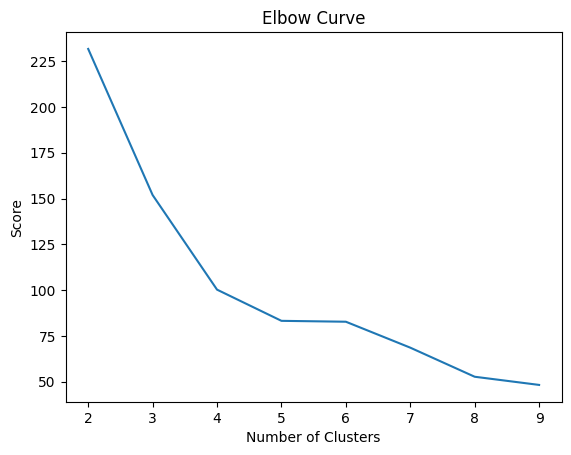

In [64]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

## 2) Building the K-Means Clustering Model

From the plot above, we can see that there is an inflection point that looks like an elbow at four. Due to this, we will proceed to build the K-Means algorithm with four clusters:

In [65]:
KMeans_algo=KMeans(featuresCol='standardized', k=5)
KMeans_fit=KMeans_algo.fit(data_scale_output)

## 3) Making Predictions

Let’s use the model we created to assign clusters to each customer in the dataset:

In [66]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+-------+---------+------------------+----------+---------------------------------+-------------------------------------------------------------+----------+
|recency|frequency|monetary_value    |CustomerID|features                         |standardized                                                 |prediction|
+-------+---------+------------------+----------+---------------------------------+-------------------------------------------------------------+----------+
|5580   |14       |226.14            |16250     |[5580.0,14.0,226.14]             |[0.6860448646904731,0.6848507976304103,0.3387959081995723]   |2         |
|2580   |1        |350.4             |15100     |[2580.0,1.0,350.4]               |[0.31720353958806824,0.048917914116457885,0.5249583719515792]|2         |
|30360  |14       |205.85999999999999|13065     |[30360.0,14.0,205.85999999999999]|[3.732674210036338,0.6848507976304103,0.3084130435215528]    |1         |
|12660  |59       |416.78999999999996|12838     |[12660.0,

# Step 6: Cluster Analysis

The final step in this entire tutorial is to analyze the customer segments we just built.

Run the following lines of code to visualize the recency, frequency, and monetary value of each customerID in the dataframe:

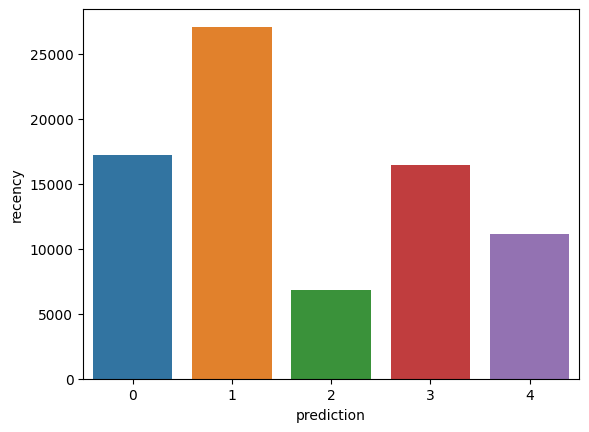

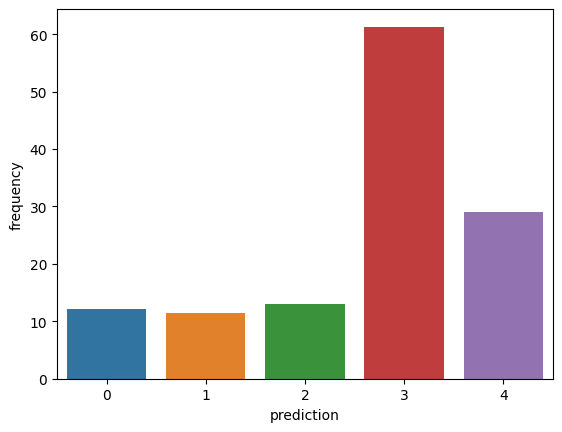

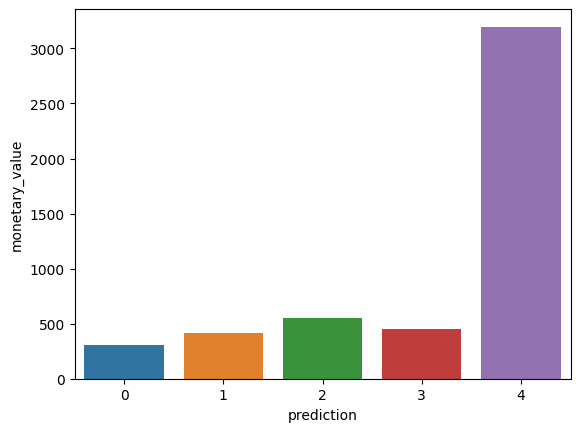

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

Review above charts to provide insights.

In [38]:
spark.stop()